In [2]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs

subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

from numpy.polynomial.legendre import Legendre
from sklearn.linear_model import LinearRegression


def make_poly_regressors(n_samples, order=2):
    X = np.ones((n_samples, 0))
    for d in range(order):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    return X


def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data


calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))

subjects = []
subjects_runs = {}
for key in list(valid_data.keys()):
    subjects.append(key[0])
    if not subjects_runs.keys().__contains__(key[0]):
        subjects_runs[key[0]] = 0
    subjects_runs[key[0]] += 1
subjects = list(set(subjects))
subjects.sort()

print(len(subjects), subjects)
print("average number of runs:", np.mean(list(subjects_runs.values())),
      "+-", np.std(list(subjects_runs.values())))

18 ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-015', 'sub-016', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-PBJ']
average number of runs: 7.388888888888889 +- 3.0393509703533175


In [5]:
mocet_calibration_errors = {}
mocet_validation_errors = {}

for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                if not mocet_calibration_errors.keys().__contains__(subject):
                    mocet_calibration_errors[subject] = []
                    mocet_validation_errors[subject] = []

                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'

                simulation_root = f'../../data/simulation/1.0/{subject}/{session}'
                simulation_fname = f'{simulation_root}/{subject}_{session}_{task}_{run}_simulation-eyetracking.csv'
                simulation_data = pd.read_csv(simulation_fname)

                model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
                # Rendered image in simulation is flipped along x-axis
                model_pupil_data[:, 0] = -simulation_data['center_x']
                model_pupil_data[:, 1] = simulation_data['center_y']
                model_pupil_size[:, 0] = simulation_data['diameter_px']

                pupil_simulation_x = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                pupil_simulation_y = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])

                avg_pupil_diameter_mm = 5
                pupil_diameter_mm_per_px = avg_pupil_diameter_mm / np.nanmean(model_pupil_size)
                pupil_data_new = np.zeros_like(model_pupil_data)
                pupil_data_new[:, 0] = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                pupil_data_new[:, 1] = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])
                pupil_data_new = pupil_data_new * pupil_diameter_mm_per_px

                model_pupil_data = mocet.apply_mocet(pupil_data=pupil_data_new,
                                                     motion_params_fname=confounds_fname,
                                                     large_motion_params=False,
                                                     polynomial_order=3)

                t_cal = 0
                t_val = 1

                offset = calibration_onsets[t_cal]
                calibration_pupils = []
                for i in np.arange(calibration_points[t_cal]):
                    start = (offset + i)
                    calibration_pupils.append([np.nanmean(model_pupil_data[start, 0]),
                                               np.nanmean(model_pupil_data[start, 1])])
                calibration_pupils = np.array(calibration_pupils)

                repeat = True if calibration_points[t_cal] == 24 else False
                calibrator = mocet.EyetrackingCalibration(calibration_coordinates=calibration_coordinates,
                                                          calibration_order=calibration_order,
                                                          repeat=repeat)
                calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                gaze_coordinates = calibrator.transform(model_pupil_data)

                for t in [t_cal, t_val]:
                    MSE = []
                    offset = calibration_onsets[t]
                    for i in np.arange(calibration_points[t]):
                        ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                        ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                        start = (offset + i)
                        data_x = np.nanmean(gaze_coordinates[start, 0])
                        data_y = np.nanmean(gaze_coordinates[start, 1])
                        MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                    if t == t_cal:
                        calibration_error = np.nanmean(MSE) / px_per_deg
                        mocet_calibration_errors[subject].append(calibration_error)
                    elif t == t_val:
                        validation_error = np.nanmean(MSE) / px_per_deg
                        mocet_validation_errors[subject].append(validation_error)
                print(key, calibration_error, validation_error)

subjects_mocet_calibration_errors = []
subjects_mocet_validation_errors = []
for key in mocet_calibration_errors.keys():
    subjects_mocet_calibration_errors.append(np.mean(mocet_calibration_errors[key], axis=0))
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[key], axis=0))

print(np.mean(subjects_mocet_calibration_errors), np.mean(subjects_mocet_validation_errors))
with open(f'../../data/error/mocet_calibration_error_model.pkl', 'wb') as f:
    pickle.dump(mocet_calibration_errors, f)
with open(f'../../data/error/mocet_validation_error_model.pkl', 'wb') as f:
    pickle.dump(mocet_validation_errors, f)

('sub-003', 'ses-07R', 'task-mcHERDING', 'run-1') 2.673966750992789e-15 0.3539250828695532
('sub-003', 'ses-07R', 'task-mcHERDING', 'run-2') 3.702650084757446e-15 0.35150641672544475
('sub-003', 'ses-07R', 'task-mcHERDING', 'run-3') 2.7847240271923932e-15 0.35858991825337644
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-1') 2.8657518219851907e-15 0.1834629131137775
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-2') 3.910968179287457e-15 0.2658889151767274
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-3') 2.4240604748855265e-15 0.33129749474682113
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-4') 4.340676420757793e-15 0.21829002632178607
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-5') 3.3053024820803515e-15 0.5705224179875592
('sub-003', 'ses-13R', 'task-mcHERDING', 'run-7') 3.4701194571346554e-15 0.49301770947771345
('sub-004', 'ses-07R', 'task-mcHERDING', 'run-1') 5.229794713722212e-15 0.2444613143602657
('sub-004', 'ses-07R', 'task-mcHERDING', 'run-2') 4.249118701946814e-15 0.210494

In [8]:
from scipy.stats import ttest_rel

for p in range(1, 13):
    polynomial_calibration_errors = {}
    polynomial_validation_errors = {}
    
    for subject in subjects:
        sessions = subject_pool[subject].keys()
        for session in sessions:
            runs = subject_pool[subject][session]
            root = f'{project_dir}/data/eyetracking/{subject}/{session}'
            for r in runs:
                run = f'run-{r}'
                np.random.seed(0)
                key = (subject, session, task, run)
                if key in valid_data.keys():
                    if not polynomial_calibration_errors.keys().__contains__(subject):
                        polynomial_calibration_errors[subject] = []
                        polynomial_validation_errors[subject] = []

                    confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'

                    simulation_root = f'../../data/simulation/1.0/{subject}/{session}'
                    simulation_fname = f'{simulation_root}/{subject}_{session}_{task}_{run}_simulation-eyetracking.csv'
                    simulation_data = pd.read_csv(simulation_fname)

                    model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
                    # Rendered image in simulation is flipped along x-axis
                    model_pupil_data[:, 0] = -simulation_data['center_x']
                    model_pupil_data[:, 1] = simulation_data['center_y']
                    model_pupil_size[:, 0] = simulation_data['diameter_px']

                    pupil_simulation_x = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                    pupil_simulation_y = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])

                    avg_pupil_diameter_mm = 5
                    pupil_diameter_mm_per_px = avg_pupil_diameter_mm / np.nanmean(model_pupil_size)
                    pupil_data_new = np.zeros_like(model_pupil_data)
                    pupil_data_new[:,0] = model_pupil_data[:,0] - np.mean(model_pupil_data[:25,0])
                    pupil_data_new[:,1] = model_pupil_data[:,1] - np.mean(model_pupil_data[:25,1])
                    pupil_data_new = pupil_data_new * pupil_diameter_mm_per_px
                
                    model_pupil_data = polynomial_detrending(pupil_data_new, polynomial_order=p)
                    
                    t_cal = 0
                    t_val = 1

                    offset = calibration_onsets[t_cal]
                    calibration_pupils = []
                    for i in np.arange(calibration_points[t_cal]):
                        start = (offset+i)
                        calibration_pupils.append([np.nanmean(model_pupil_data[start,0]),
                                                   np.nanmean(model_pupil_data[start,1])])
                    calibration_pupils = np.array(calibration_pupils)

                    repeat = True if calibration_points[t_cal]==24 else False
                    calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                                              calibration_order = calibration_order,
                                                              repeat=repeat)
                    calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                    gaze_coordinates = calibrator.transform(model_pupil_data)
                
                    for t in [t_cal, t_val]:
                        MSE = []
                        offset = calibration_onsets[t]
                        for i in np.arange(calibration_points[t]):
                            ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                            ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                            start = (offset+i)
                            data_x = np.nanmean(gaze_coordinates[start,0])
                            data_y = np.nanmean(gaze_coordinates[start,1])
                            MSE.append(np.sqrt((ref_x-data_x)**2 + (ref_y-data_y)**2))
                        if t == t_cal:
                            calibration_error = np.nanmean(MSE)/px_per_deg
                            polynomial_calibration_errors[subject].append(calibration_error)
                        elif t == t_val:
                            validation_error = np.nanmean(MSE)/px_per_deg
                            polynomial_validation_errors[subject].append(validation_error)
    with open(f'../../data/error/polynomial_calibration_error_p{p:02d}_model.pkl', 'wb') as f:
        pickle.dump(polynomial_calibration_errors, f)
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}_model.pkl', 'wb') as f:
        pickle.dump(polynomial_validation_errors, f)

    subjects_polynomial_calibration_errors = []
    subjects_polynomial_validation_errors = []
    for key in mocet_calibration_errors.keys():
        subjects_polynomial_calibration_errors.append(np.mean(polynomial_calibration_errors[key], axis=0))
        subjects_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[key], axis=0))
        
    print(p, ttest_rel(subjects_mocet_validation_errors, subjects_polynomial_validation_errors))

1 TtestResult(statistic=np.float64(-9.657558408201803), pvalue=np.float64(2.5738926900256318e-08), df=np.int64(17))
2 TtestResult(statistic=np.float64(-9.477574173322113), pvalue=np.float64(3.3795039491116765e-08), df=np.int64(17))
3 TtestResult(statistic=np.float64(-7.989158097011455), pvalue=np.float64(3.717936688079929e-07), df=np.int64(17))
4 TtestResult(statistic=np.float64(-7.843654838696752), pvalue=np.float64(4.770180218397198e-07), df=np.int64(17))
5 TtestResult(statistic=np.float64(-6.223682319664385), pvalue=np.float64(9.259008644790163e-06), df=np.int64(17))
6 TtestResult(statistic=np.float64(-7.476904506934053), pvalue=np.float64(9.050903280845405e-07), df=np.int64(17))
7 TtestResult(statistic=np.float64(-7.168549599121441), pvalue=np.float64(1.57247581431602e-06), df=np.int64(17))
8 TtestResult(statistic=np.float64(-5.226602899228727), pvalue=np.float64(6.839562323288531e-05), df=np.int64(17))
9 TtestResult(statistic=np.float64(-5.38858811146639), pvalue=np.float64(4.9007

In [9]:
uncorrected_calibration_errors = {}
uncorrected_validation_errors = {}

for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                if not uncorrected_calibration_errors.keys().__contains__(subject):
                    uncorrected_calibration_errors[subject] = []
                    uncorrected_validation_errors[subject] = []

                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'

                simulation_root = f'../../data/simulation/1.0/{subject}/{session}'
                simulation_fname = f'{simulation_root}/{subject}_{session}_{task}_{run}_simulation-eyetracking.csv'
                simulation_data = pd.read_csv(simulation_fname)

                model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
                # Rendered image in simulation is flipped along x-axis
                model_pupil_data[:, 0] = -simulation_data['center_x']
                model_pupil_data[:, 1] = simulation_data['center_y']
                model_pupil_size[:, 0] = simulation_data['diameter_px']

                pupil_simulation_x = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                pupil_simulation_y = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])

                avg_pupil_diameter_mm = 5
                pupil_diameter_mm_per_px = avg_pupil_diameter_mm / np.nanmean(model_pupil_size)
                pupil_data_new = np.zeros_like(model_pupil_data)
                pupil_data_new[:,0] = model_pupil_data[:,0] - np.mean(model_pupil_data[:25,0])
                pupil_data_new[:,1] = model_pupil_data[:,1] - np.mean(model_pupil_data[:25,1])
                pupil_data_new = pupil_data_new * pupil_diameter_mm_per_px

                t_cal = 0
                t_val = 1

                offset = calibration_onsets[t_cal]
                calibration_pupils = []
                for i in np.arange(calibration_points[t_cal]):
                    start = (offset+i)
                    calibration_pupils.append([np.nanmean(model_pupil_data[start,0]),
                                               np.nanmean(model_pupil_data[start,1])])
                calibration_pupils = np.array(calibration_pupils)
                # To avoid singularity error, we need to add tiny EPS to pupil location
                calibration_pupils += np.random.normal(0, 1e-12, calibration_pupils.shape)

                repeat = True if calibration_points[t_cal]==24 else False
                calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                                          calibration_order = calibration_order,
                                                          repeat=repeat)
                calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                gaze_coordinates = calibrator.transform(model_pupil_data)
            
                for t in [t_cal, t_val]:
                    MSE = []
                    offset = calibration_onsets[t]
                    for i in np.arange(calibration_points[t]):
                        ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                        ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                        start = (offset+i)
                        data_x = np.nanmean(gaze_coordinates[start,0])
                        data_y = np.nanmean(gaze_coordinates[start,1])
                        MSE.append(np.sqrt((ref_x-data_x)**2 + (ref_y-data_y)**2))
                    if t == t_cal:
                        calibration_error = np.nanmean(MSE)/px_per_deg
                        uncorrected_calibration_errors[subject].append(calibration_error)
                    elif t == t_val:
                        validation_error = np.nanmean(MSE)/px_per_deg
                        uncorrected_validation_errors[subject].append(validation_error)

subjects_uncorrected_calibration_errors = []
subjects_uncorrected_validation_errors = []
for key in mocet_calibration_errors.keys():
    subjects_uncorrected_calibration_errors.append(np.mean(uncorrected_calibration_errors[key], axis=0))
    subjects_uncorrected_validation_errors.append(np.mean(uncorrected_validation_errors[key], axis=0))
    
print(np.mean(subjects_uncorrected_calibration_errors), np.mean(subjects_uncorrected_validation_errors))

with open(f'../../data/error/uncorrected_calibration_error_model.pkl', 'wb') as f:
    pickle.dump(uncorrected_calibration_errors, f)
with open(f'../../data/error/uncorrected_validation_error_model.pkl', 'wb') as f:
    pickle.dump(uncorrected_validation_errors, f)


1.5730881041532713e-12 4.391790004119669


(4, 18)
[0.32985812 1.81080796 4.17049179 4.39179   ]


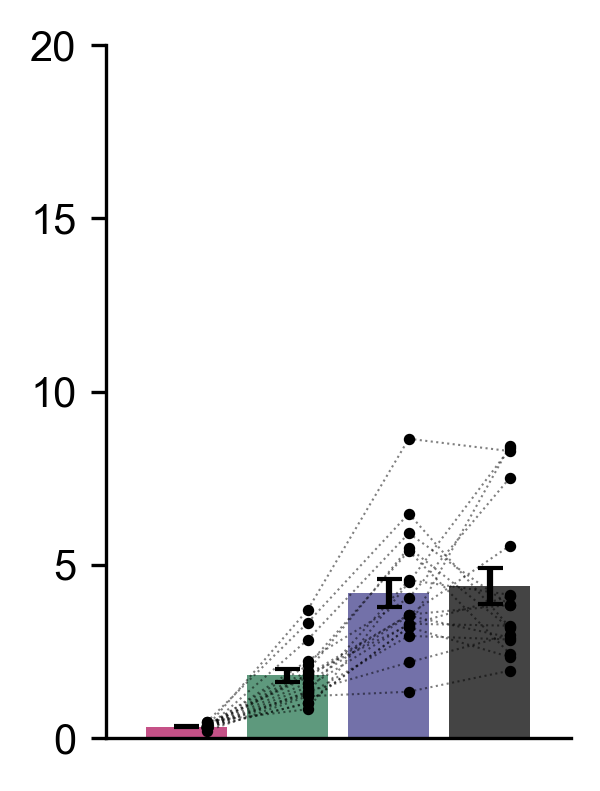

In [14]:
with open(f'../../data/error/mocet_validation_error_model.pkl', 'rb') as f:
    mocet_validation_errors = pickle.load(f)
subjects_mocet_validation_errors = []
for subject in subjects:
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[subject], axis=0))

with open(f'../../data/error/uncorrected_validation_error_model.pkl', 'rb') as f:
    uncorrected_validation_errors = pickle.load(f)
subjects_uncorrected_validation_errors = []
for subject in subjects:
    subjects_uncorrected_validation_errors.append(np.mean(uncorrected_validation_errors[subject], axis=0))

subjects_polynomial_validation_errors = []
for p in [1,3]:
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}_model.pkl', 'rb') as f:
        polynomial_validation_errors = pickle.load(f)
    #subjects_polynomial_calibration_errors = []
    subject_polynomial_validation_errors = []
    for subject in subjects:
        #subjects_polynomial_calibration_errors.append(np.mean(polynomial_calibration_errors[key], axis=0))
        subject_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[subject], axis=0))
    subjects_polynomial_validation_errors.append(subject_polynomial_validation_errors)

from scipy.stats import sem, ttest_rel, ttest_ind
plt.style.use('default')

# Define the tags for the errors
tags = ['mocet', 'polynomial', 'linear', 'uncorrected']

MSE_matrix = np.concatenate([
    np.array(subjects_mocet_validation_errors).reshape(1,-1),
    np.flip(np.array(subjects_polynomial_validation_errors), axis=0),
    np.array(subjects_uncorrected_validation_errors).reshape(1,-1)
], axis=0)
print(MSE_matrix.shape)
print(np.mean(MSE_matrix, axis=1))
#color_list = ['#c55187']+['#5e997d']*3+['#444444']
color_list = ['#c55187','#5e997d', '#7371a9', '#444444']

fig, ax = plt.subplots(1, 1, figsize=(2,3), dpi=300,  sharex=True)

ax.bar(np.arange(1+2+1),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list)

# # Add scatter points to the box plot
for i in range(1+2+1):
    ax.scatter(np.ones(len(subjects_mocet_validation_errors)) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(len(subjects_mocet_validation_errors)):
    for i in range(1+2):
        ax.plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_xlim(-0.8, 3.8)
ax.set_yticks([0, 5, 10, 15, 20])
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

In [11]:
print(ttest_rel(subjects_mocet_validation_errors, MSE_matrix[1]))
print(ttest_rel(subjects_mocet_validation_errors, MSE_matrix[2]))
print(ttest_rel(subjects_mocet_validation_errors, MSE_matrix[3]))

TtestResult(statistic=np.float64(-7.989158097011455), pvalue=np.float64(3.717936688079929e-07), df=np.int64(17))
TtestResult(statistic=np.float64(-9.657558408201803), pvalue=np.float64(2.5738926900256318e-08), df=np.int64(17))
TtestResult(statistic=np.float64(-7.831632337836367), pvalue=np.float64(4.870025593517614e-07), df=np.int64(17))


(14, 18)


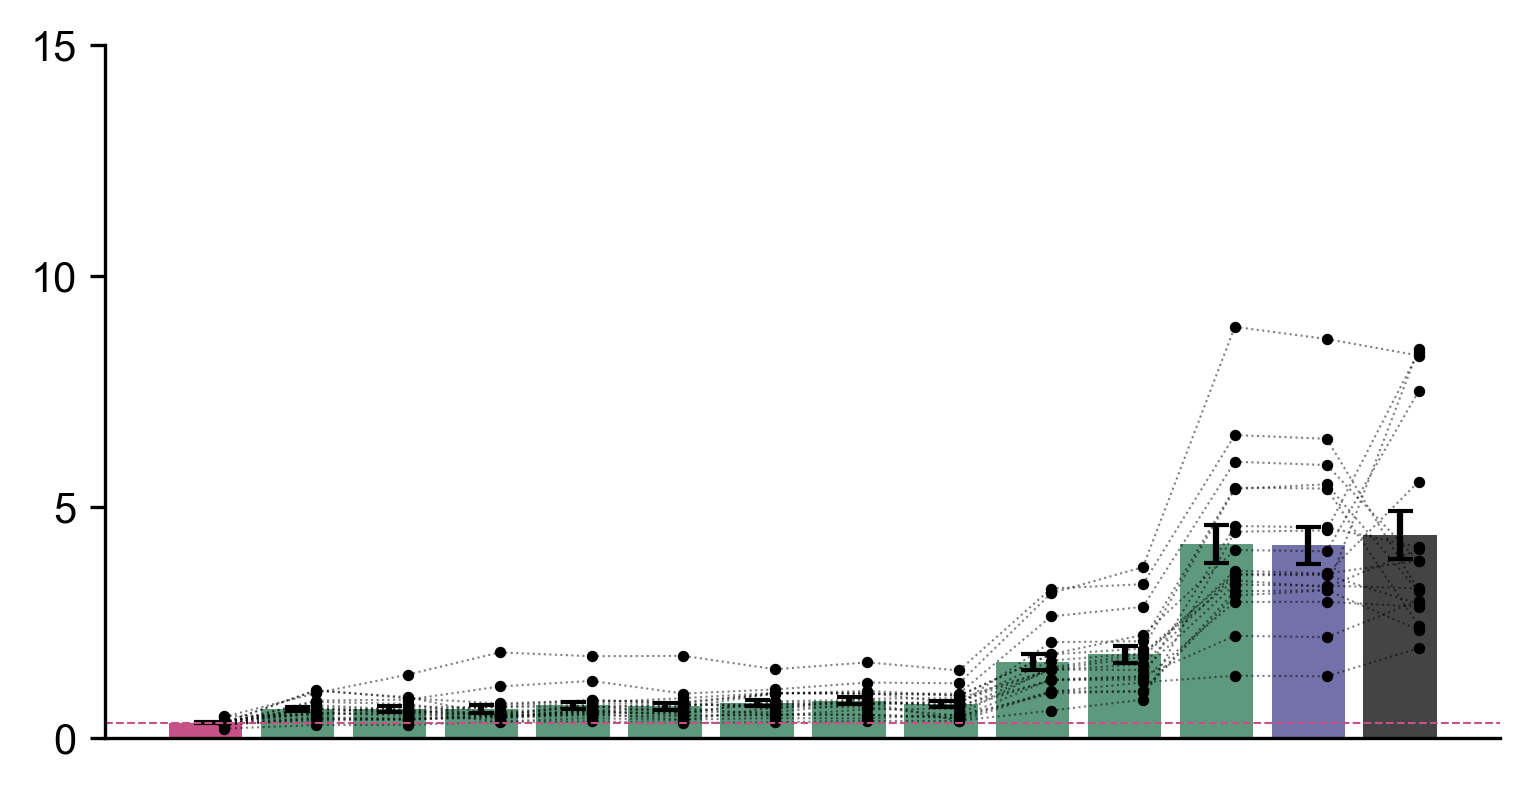

In [12]:
with open(f'../../data/error/mocet_validation_error_model.pkl', 'rb') as f:
    mocet_validation_errors = pickle.load(f)
subjects_mocet_validation_errors = []
for subject in subjects:
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[subject], axis=0))

with open(f'../../data/error/uncorrected_validation_error_model.pkl', 'rb') as f:
    uncorrected_validation_errors = pickle.load(f)
subjects_uncorrected_validation_errors = []
for subject in subjects:
    subjects_uncorrected_validation_errors.append(np.mean(uncorrected_validation_errors[subject], axis=0))

subjects_polynomial_validation_errors = []
for p in range(1,13):
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}_model.pkl', 'rb') as f:
        polynomial_validation_errors = pickle.load(f)
    #subjects_polynomial_calibration_errors = []
    subject_polynomial_validation_errors = []
    for subject in subjects:
        #subjects_polynomial_calibration_errors.append(np.mean(polynomial_calibration_errors[key], axis=0))
        subject_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[subject], axis=0))
    subjects_polynomial_validation_errors.append(subject_polynomial_validation_errors)

from scipy.stats import sem, ttest_rel, ttest_ind
plt.style.use('default')

# Define the tags for the errors
tags = ['mocet', 'polynomial', 'linear', 'uncorrected']

MSE_matrix = np.concatenate([
    np.array(subjects_mocet_validation_errors).reshape(1,-1),
    np.flip(np.array(subjects_polynomial_validation_errors), axis=0),
    np.array(subjects_uncorrected_validation_errors).reshape(1,-1)
], axis=0)
print(MSE_matrix.shape)

color_list = ['#c55187']+['#5e997d']*11+['#7371a9', '#444444']
#color_list = ['#c55187','#5e997d', '#7371a9', '#444444']

fig, ax = plt.subplots(1, 1, figsize=(6,3), dpi=300,  sharex=True)
ax.bar(np.arange(MSE_matrix.shape[0]),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list)

# # Add scatter points to the box plot
for i in range(MSE_matrix.shape[0]):
    ax.scatter(np.ones(len(subjects_mocet_validation_errors)) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(len(subjects_mocet_validation_errors)):
    for i in range(MSE_matrix.shape[0]-1):
        ax.plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 5, 10, 15])
ax.axhline(np.mean(MSE_matrix, axis=1)[0], c='#c55187', linestyle='--', lw=0.5)

for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

In [13]:
from scipy.stats import ttest_rel

with open(f'../../data/error/mocet_validation_error_model.pkl', 'rb') as f:
    mocet_validation_errors = pickle.load(f)
subjects_mocet_validation_errors = []
for key in mocet_calibration_errors.keys():
    subjects_mocet_validation_errors.append(np.mean(mocet_validation_errors[key], axis=0))


for p in range(1, 13):
    with open(f'../../data/error/polynomial_validation_error_p{p:02d}_model.pkl', 'rb') as f:
        polynomial_validation_errors = pickle.load(f)

    subjects_polynomial_validation_errors = []
    for key in mocet_calibration_errors.keys():
        subjects_polynomial_validation_errors.append(np.mean(polynomial_validation_errors[key], axis=0))

    print(p, np.mean(subjects_polynomial_validation_errors), ttest_rel(subjects_mocet_validation_errors, subjects_polynomial_validation_errors))


1 4.170491791097501 TtestResult(statistic=np.float64(-9.657558408201803), pvalue=np.float64(2.5738926900256318e-08), df=np.int64(17))
2 4.197890729765287 TtestResult(statistic=np.float64(-9.477574173322113), pvalue=np.float64(3.3795039491116765e-08), df=np.int64(17))
3 1.8108079615356718 TtestResult(statistic=np.float64(-7.989158097011455), pvalue=np.float64(3.717936688079929e-07), df=np.int64(17))
4 1.6489285746713869 TtestResult(statistic=np.float64(-7.843654838696752), pvalue=np.float64(4.770180218397198e-07), df=np.int64(17))
5 0.7339584703845438 TtestResult(statistic=np.float64(-6.223682319664385), pvalue=np.float64(9.259008644790163e-06), df=np.int64(17))
6 0.8074580121088455 TtestResult(statistic=np.float64(-7.476904506934053), pvalue=np.float64(9.050903280845405e-07), df=np.int64(17))
7 0.7528962280281188 TtestResult(statistic=np.float64(-7.168549599121441), pvalue=np.float64(1.57247581431602e-06), df=np.int64(17))
8 0.6874099291220743 TtestResult(statistic=np.float64(-5.226602